
<p><b>	Data_Analysis.py </b> </p></bl>
	Created on: Nov 25th, 2018
       Author: Ryan Dreifuerst
	
Analyzes the data collected from the IO subsystem and performs preliminary statistics on the features.

A number of different machine learning models are considered using k-folds on a train, validation, and test set. Through initial investigations a random forrest classifier was found to be an optimal design, especially after using SMOTE to over sample the fall data to give the models an even distribution of falling vs not falling. The results of a RF for the validation and test sets are then shown in a confusion matrix
	   
Last updated 1/20/19


In [18]:
# Load libraries
from IPython.display import Image
from pandas.plotting import scatter_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import _tree
from sklearn import preprocessing, model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
seed = 10                           # sets the random seed value
trees = 5

# load dataset
#columns = ["num", "dx", "dy", "dz","ddx", "ddy", "ddz","dddx", "dddy", "dddz", "accelx", "accely", "accelz", "danger"]
dataset = pd.read_csv("C:\Users\dreifuerstrm\SeniorDesign\Code\Arduino\All_Data.csv")
dataset = dataset.drop(["Num"], axis=1)
dataset = dataset.apply(pd.to_numeric)
print(dataset.head())

#new_dataset = SelectKBest(k=6).fit_transform(dataset.drop(['danger'], axis=1), dataset.danger)
#print(pd.DataFrame(new_dataset).head())

# Leads to dropping the second and third differences columns

         xavg        yavg       zavg  dx  dy  dz   ddx    ddy   ddz  dddx  \
0  169.000000  159.000000  40.000000  49  44   7   0.0    0.0   0.0   0.0   
1  193.500000  181.000000  43.500000  49  44   7   0.0    0.0   0.0   0.0   
2  208.000000  178.333333  45.000000  19 -30   1 -30.0  -74.0  -6.0 -30.0   
3  231.666667  192.333333  41.666667   3  28 -18 -16.0   58.0 -19.0  14.0   
4  223.666667  163.000000  46.000000 -46 -86  30 -49.0 -114.0  48.0 -33.0   

    dddy  dddz    x    y   z  danger  
0    0.0   0.0  169  159  40       0  
1    0.0   0.0  218  203  47       0  
2  -74.0  -6.0  237  173  48       0  
3  132.0 -13.0  240  201  30       0  
4 -172.0  67.0  194  115  60       0  


In [3]:
dataset = dataset.drop(["dddx", "dddy", "dddz","ddx", "ddy", "ddz"], axis = 1)
names = dataset.columns
print(names)

# scaling could be done, however the processor is limited
# and it was determined this is unnecessary for the desired model
'''
max_abs_scaler = MinMaxScaler()
dataset = max_abs_scaler.fit_transform(dataset)
dataset = pd.DataFrame(dataset, columns=names)
print(dataset.head())
'''

Index([u'xavg', u'yavg', u'zavg', u'dx', u'dy', u'dz', u'x', u'y', u'z',
       u'danger'],
      dtype='object')


'\nmax_abs_scaler = MinMaxScaler()\ndataset = max_abs_scaler.fit_transform(dataset)\ndataset = pd.DataFrame(dataset, columns=names)\nprint(dataset.head())\n'

would you like graphs? 1 = yes, else no1
              xavg         yavg         zavg           dx           dy  \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000   
mean    112.084324   109.057174   110.918648    -0.663496    -0.854340   
std     156.123598   125.097047   109.802025   216.140195   222.130463   
min    -498.000000 -1381.333333  -435.000000 -3716.000000 -4528.000000   
25%      33.000000    67.666667    48.750000   -19.000000   -17.000000   
50%     111.333333   126.666667   115.333333     0.000000     0.000000   
75%     216.583333   174.333333   173.916667    21.000000    15.000000   
max    1599.333333   782.000000  1233.000000  3375.000000  4317.000000   

                dz            x            y            z       danger  
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000  
mean     -0.499405   111.866825   108.407253   110.719382     0.164090  
std     168.853837   202.269703   179.606818   150.743258     0.370468  


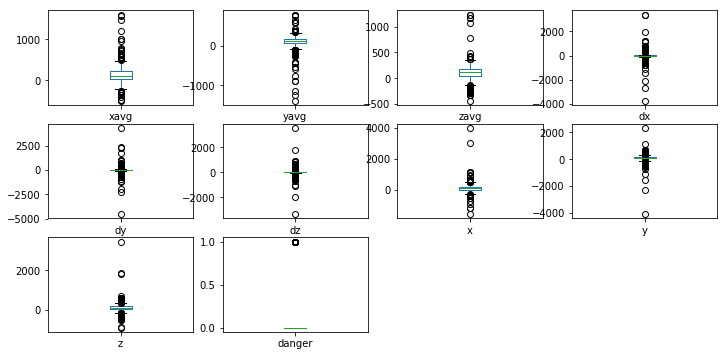

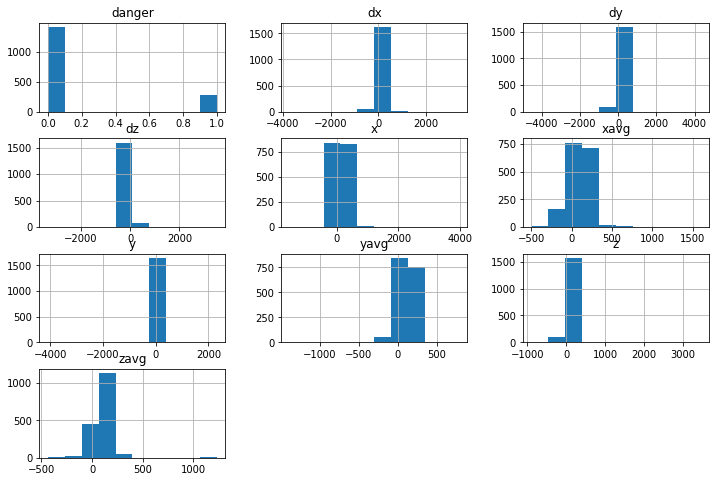

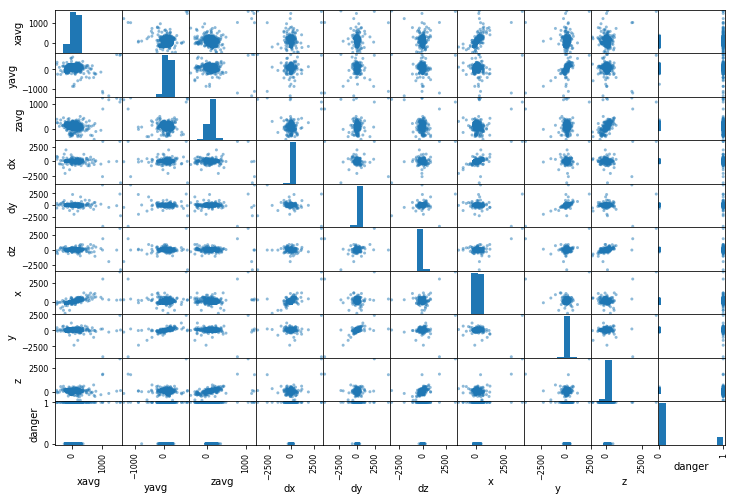

In [9]:
graphs = raw_input("would you like graphs? 1 = yes, else no")
if graphs == '1':
    #basic statistics for the dataset
    print(dataset.describe())

    # box and whisker plots of each variable
    dataset.plot(kind = 'box', subplots=True, layout = (4,4), sharex=False, sharey = False)
    plt.show()

    # histogram
    dataset.hist()
    plt.show()

    # scatter plot matrix
    scatter_matrix(dataset)
    plt.show()

In [10]:
# split the datat into training and testing
x = dataset.drop(['danger'], axis = 1)
col = x.columns
y = dataset.danger


validation_size = 0.20             # 20% test size
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = validation_size, random_state = seed)
sm = SMOTE(random_state = seed)
x_train, y_train = sm.fit_resample(x_train, y_train)
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train, test_size = validation_size, random_state= seed)


Adding minority oversampling greatly improves the split for the random forest/decision trees, making the model more effective at classifiying a fall, 1, which is much less common than non-falling data. It is important to note that there is no oversampling being done on the test data, but there is on validation.

In [11]:
scoring = 'accuracy'

models = []
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(max_depth=8, min_samples_leaf=8)))
models.append(('NB', GaussianNB()))

results = []
names = []
for name, model in models:
	# test harness wil split data into 10 parts
    kfold = model_selection.KFold(n_splits=10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.633491 (0.027855)
LDA: 0.634618 (0.035449)
KNN: 0.925604 (0.029742)
DT: 0.851692 (0.023979)
NB: 0.758245 (0.022277)


a KNN algorithm would likely be effective, although the over sampled data is based on this so the results are also skewed in this sense. KNN is also not particularly resource efficient, which is required for an embedded situation like a small wrist watch is. The DT is decent, although easily overfit, so a random forest can be used to improve the model and reduce variance.

In [12]:
# next decide which is best. Then run a full accuracy score, confusion matrix, and classification report
clf = RandomForestClassifier(n_estimators=trees, max_depth=6, min_samples_leaf=8, random_state=seed) #, class_weight={0:0.4, 1:0.2})
#clf = DecisionTreeClassifier( random_state=seed, min_samples_leaf=0.1)
clf.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [14]:
print("----------------------Train Results--------------------------")
pred = clf.predict(x_train)
print(accuracy_score(y_train, pred))
print(confusion_matrix(y_train, pred))
print(classification_report(y_train, pred))

print("----------------------Valid Results--------------------------")
predictions = clf.predict(x_valid)
print(accuracy_score(y_valid, predictions))
print(confusion_matrix(y_valid, predictions))
print(classification_report(y_valid, predictions))


print("----------------------Test Results--------------------------")
test_pred = clf.predict(x_test)
print(accuracy_score(y_test, test_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred))

----------------------Train Results--------------------------
0.898153329602686
[[815  72]
 [110 790]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       887
           1       0.92      0.88      0.90       900

   micro avg       0.90      0.90      0.90      1787
   macro avg       0.90      0.90      0.90      1787
weighted avg       0.90      0.90      0.90      1787

----------------------Valid Results--------------------------
0.8747203579418344
[[207  23]
 [ 33 184]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       230
           1       0.89      0.85      0.87       217

   micro avg       0.87      0.87      0.87       447
   macro avg       0.88      0.87      0.87       447
weighted avg       0.88      0.87      0.87       447

----------------------Test Results--------------------------
0.8931750741839762
[[256  33]
 [  3  45]]
              precision    recall  f

The results are fairly good, and the model is behaving in a desireable fashion, which is to maximize recall of '1' to ensure that in the even of uncertainty, a fall should be predicted to ensure most falls are caught, even if there are some false alarms.

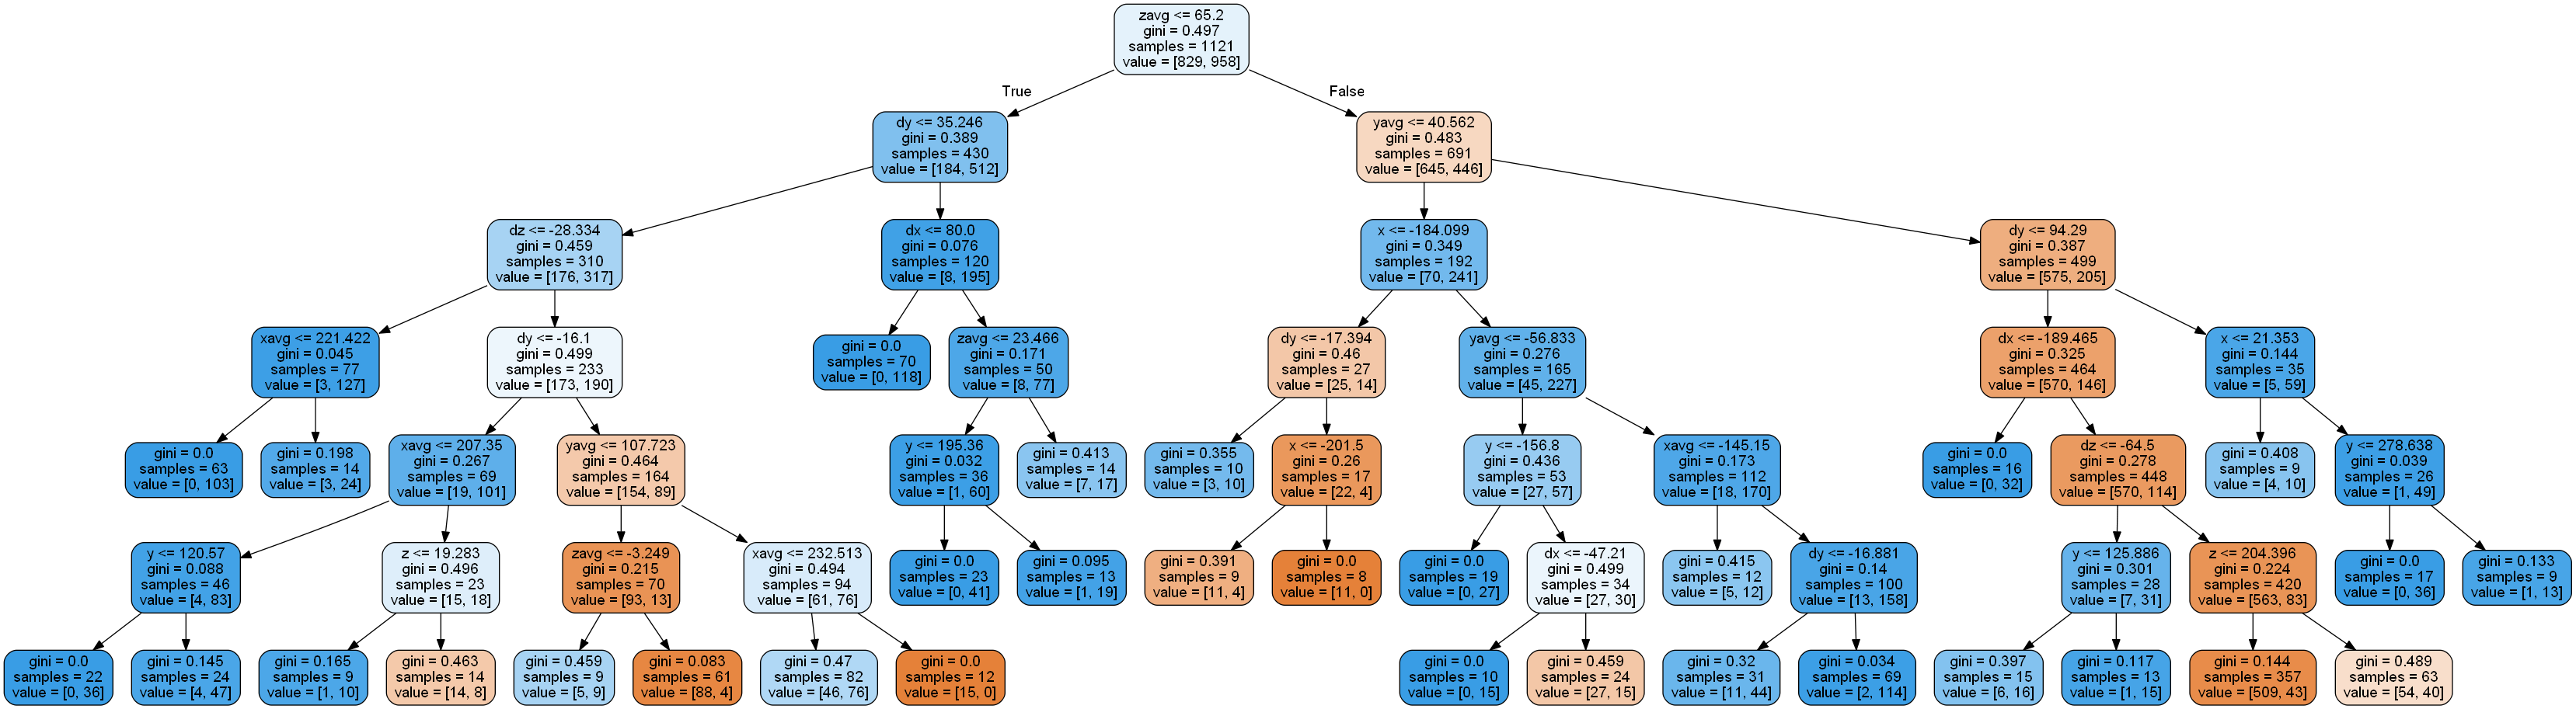

In [46]:
# generate some pictures for viewing
if(type(clf) == type(DecisionTreeClassifier())):
    with open("Wrist_Rescue.dot", 'w') as f:
        f = export_graphviz(clf, out_file=f, feature_names=col,
                        filled=True, rounded=True)
else:
    if(type(clf) == type(RandomForestClassifier())):
        for i in range(trees):
            with open("Wrist_Rescue_{}.dot".format(i), 'w') as f:
                f = export_graphviz(clf.estimators_[i], out_file=f, feature_names=col,
                                filled=True, rounded=True)

# to generate plot:
# at the command line, run this to convert to PNG:
# must cd to the correct folder!
# dot -Tpng Wrist_Rescue.dot -o Wrist_rescue.png
PATH = '/Users/dreifuerstrm/SeniorDesign/Code/CPU/'

# Show one of the five trees
Image(filename = PATH + "Wrist_Rescue_0.png", width=1200)


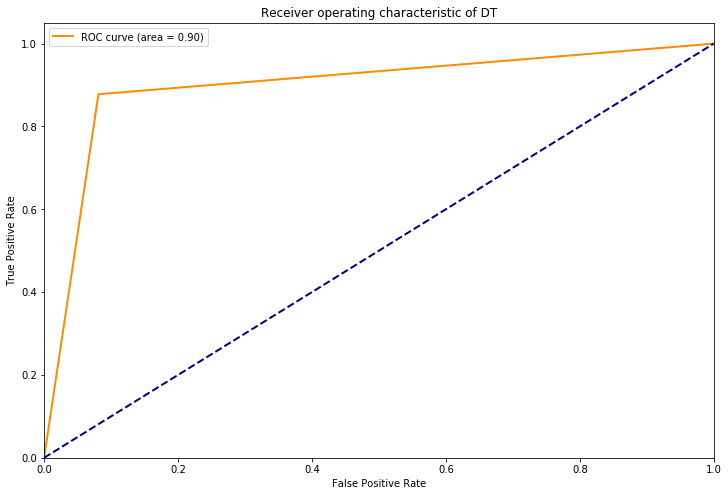

In [25]:
# genearte ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_train, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of DT')
plt.legend(loc="best")
plt.show()


In [44]:
# define a function to generate code for the decision tree
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print "def tree({}):".format(", ".join(feature_names))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print "{}if {} <= {}:".format(indent, name, int(np.round(threshold, 0)))
            recurse(tree_.children_left[node], depth + 1)
            print "{}else:  # if {} > {}".format(indent, name, threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            print "{}return {}".format(indent, tree_.value[node])

    recurse(0, 1)

for i in range(trees):
    print("----------------Tree {} ---------------------".format(i))
    tree_to_code(clf.estimators_[i], col)

----------------Tree 0 ---------------------
def tree(xavg, yavg, zavg, dx, dy, dz, x, y, z):
  if dy <= -101:
    if zavg <= 34:
      return [[ 0. 98.]]
    else:  # if zavg > 34.2178058624
      if x <= -4:
        return [[ 0. 32.]]
      else:  # if x > -4.0
        if z <= 143:
          if y <= 87:
            if yavg <= 121:
              return [[ 2. 11.]]
            else:  # if yavg > 120.762817383
              return [[ 0. 15.]]
          else:  # if y > 87.0253448486
            return [[6. 5.]]
        else:  # if z > 142.679122925
          if zavg <= 209:
            return [[ 0. 30.]]
          else:  # if zavg > 208.94921875
            return [[ 1. 14.]]
  else:  # if dy > -101.301895142
    if dx <= -112:
      if dy <= -76:
        return [[7. 7.]]
      else:  # if dy > -75.8939552307
        if yavg <= 188:
          return [[  0. 111.]]
        else:  # if yavg > 187.588043213
          return [[5. 9.]]
    else:  # if dx > -112.118263245
      if yavg <= 41:
 